In [1]:
import os

import pandas as pd

In [2]:
from dotenv import load_dotenv

# 현재 작업 디렉토리 가져오기
current_dir = os.getcwd()  # 현재 Jupyter Notebook의 작업 디렉토
env_path = os.path.join(current_dir, '../.env')

# .env 파일 로드
load_dotenv(env_path)

True

In [3]:
db_path=os.getenv("DATA_PATH")

ecg_data=pd.read_csv(f'{db_path}/ptbxl_database.csv')
ecg_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


## ResNet 훈련

In [4]:
import torch
import torch.nn as nn
from torchvision import models

# ResNet 모델을 불러오고 사전 학습된 가중치를 사용하지 않음
model = models.resnet50(weights=None)

# 첫 번째 Conv 레이어를 수정 (in_channels=1)
model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Multi-label classification을 위해 마지막 레이어를 수정
model.fc = nn.Linear(model.fc.in_features, 5) 

In [5]:
from sklearn.metrics import roc_auc_score
import numpy as np

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

best_macro_auc = -np.inf  # macro AUC 최댓값 추적
model_path = "../common/one_stage_models/resnet_models.pth"  # 모델 저장 경로

def train_one_epoch(train_loader):
    model.train()
    total_loss = 0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        data = data.unsqueeze(1)  # 3D 데이터를 4D로 변환 (batch_size, 1, sequence_length, features)
        
        # Forward
        outputs = model(data)
        loss = loss_fn(outputs, labels)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate(val_loader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            data = data.unsqueeze(1)  # 3D 데이터를 4D로 변환 (batch_size, 1, sequence_length, features)

            outputs = model(data)
            
            # Sigmoid 후 임계값을 넘으면 1, 아니면 0으로 예측
            preds = torch.sigmoid(outputs).cpu().numpy()
            y_pred.append(preds)
            y_true.append(labels.cpu().numpy())
    
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    
    # 각 클래스별 AUC 계산 후 macro AUC 계산
    auc_per_class = []
    for i in range(y_true.shape[1]):  # 클래스마다 AUC 계산
        auc_per_class.append(roc_auc_score(y_true[:, i], y_pred[:, i]))
    macro_auc = np.mean(auc_per_class)  # macro AUC 계산
    
    return macro_auc

Epoch 1/100, Train Loss: 0.3858, Val Macro AUC: 0.8716
Best model saved with Macro AUC: 0.8716
Epoch 2/100, Train Loss: 0.3185, Val Macro AUC: 0.8281
Epoch 3/100, Train Loss: 0.2958, Val Macro AUC: 0.9072
Best model saved with Macro AUC: 0.9072
Epoch 4/100, Train Loss: 0.2815, Val Macro AUC: 0.9130
Best model saved with Macro AUC: 0.9130
Epoch 5/100, Train Loss: 0.2697, Val Macro AUC: 0.8999
Epoch 6/100, Train Loss: 0.2648, Val Macro AUC: 0.9194
Best model saved with Macro AUC: 0.9194
Epoch 7/100, Train Loss: 0.2602, Val Macro AUC: 0.9169
Epoch 8/100, Train Loss: 0.2511, Val Macro AUC: 0.9274
Best model saved with Macro AUC: 0.9274
Epoch 9/100, Train Loss: 0.2442, Val Macro AUC: 0.9200
Epoch 10/100, Train Loss: 0.2379, Val Macro AUC: 0.9234
Epoch 11/100, Train Loss: 0.2342, Val Macro AUC: 0.9282
Best model saved with Macro AUC: 0.9282
Epoch 12/100, Train Loss: 0.2290, Val Macro AUC: 0.9246
Epoch 13/100, Train Loss: 0.2233, Val Macro AUC: 0.9274
Epoch 14/100, Train Loss: 0.2202, Val Mac

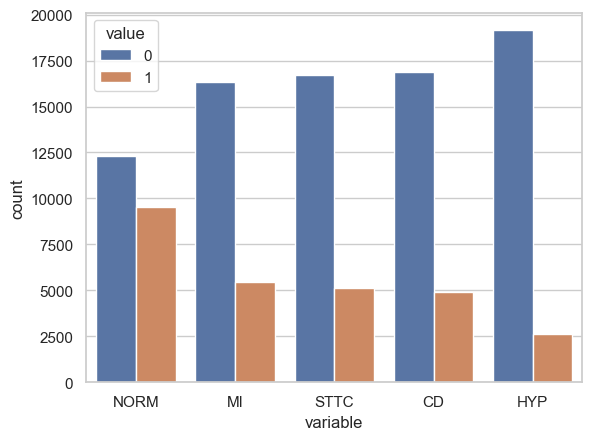

In [6]:
from ver5_journal.common.data.create_final_data import create_final_data
from ver5_journal.common.data.ECG_Data import ECG_Data
from torch.utils.data import DataLoader

# 데이터 로더 준비
label_columns = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
num_epochs = 100

# train/val/test 분리
final_data = create_final_data()
ECG_train = final_data[final_data['strat_fold'].isin([1, 2, 3, 4, 5, 6, 7, 8])].reset_index(drop=True)
ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)
# ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

train_dataset = ECG_Data(ECG_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ECG_Data(ECG_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# 모델 정의 및 학습
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# 학습 루프
for epoch in range(num_epochs):
    train_loss = train_one_epoch(train_loader)
    macro_auc = validate(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Macro AUC: {macro_auc:.4f}")
    
    # Macro AUC가 최고일 때 모델 저장
    if macro_auc > best_macro_auc:
        best_macro_auc = macro_auc
        torch.save(model.state_dict(), model_path)
        print(f"Best model saved with Macro AUC: {best_macro_auc:.4f}")
